In [ ]:
!pip install xgboost


  Using cached xgboost-3.0.0-py3-none-win_amd64.whl.metadata (2.1 kB)
Using cached xgboost-3.0.0-py3-none-win_amd64.whl (150.0 MB)


In [ ]:
from sklearn.datasets import load_breast_cancer
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score

In [ ]:
import sys
print(sys.executable)


C:\Users\user\anaconda3\python.exe


In [ ]:
data=load_breast_cancer()
df=pd.DataFrame(data.data,columns=data.feature_names)
df['target']=data.target
x=data.data
y=data.target
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

In [ ]:
# Drop selected features
df_cleaned = df.drop(columns=[
    "mean perimeter", "mean area", "mean concave points",
    "perimeter error", "area error", "worst perimeter",
    "worst area", "worst texture"
])

# Split features (X) and target (y)
X = df_cleaned.drop(columns=["target"])
y = df_cleaned["target"]


In [ ]:
from sklearn.model_selection import train_test_split

# Split dataset (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)

Training set size: (455, 22)
Test set size: (114, 22)


In [ ]:
from imblearn.over_sampling import SMOTE

# Initialize SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)

# Apply SMOTE to generate synthetic malignant cases
X_resampled, y_resampled = smote.fit_resample(X, y)

# Check new class distribution
print("New Class Distribution After SMOTE:")
print(pd.Series(y_resampled).value_counts())

New Class Distribution After SMOTE:
target
0    357
1    357
Name: count, dtype: int64


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [ ]:

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Initialize the model
xgb_model = XGBClassifier(eval_metric="logloss", random_state=42)

# Train the model
xgb_model.fit(X_train_scaled, y_train)

# Now, make predictions
y_pred = xgb_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)

In [ ]:
accuracy

0.972027972027972

In [ ]:
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.97        74
           1       0.99      0.96      0.97        69

    accuracy                           0.97       143
   macro avg       0.97      0.97      0.97       143
weighted avg       0.97      0.97      0.97       143



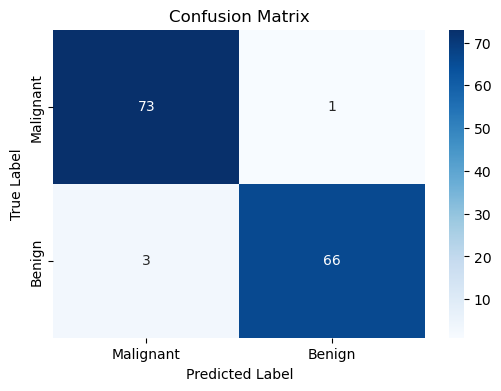

In [ ]:
# Plot Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Malignant", "Benign"], yticklabels=["Malignant", "Benign"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


🔹 Top Features for Deployment:
                   Feature  Importance
15            worst radius    0.416429
19    worst concave points    0.173640
8            texture error    0.092878
5            mean symmetry    0.045094
18         worst concavity    0.035130
0              mean radius    0.031643
11         concavity error    0.025495
1             mean texture    0.025197
6   mean fractal dimension    0.019145
7             radius error    0.016048


C:\Users\user\AppData\Local\Temp\ipykernel_18784\998306506.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importance_df["Importance"][:10], y=importance_df["Feature"][:10], palette="viridis")


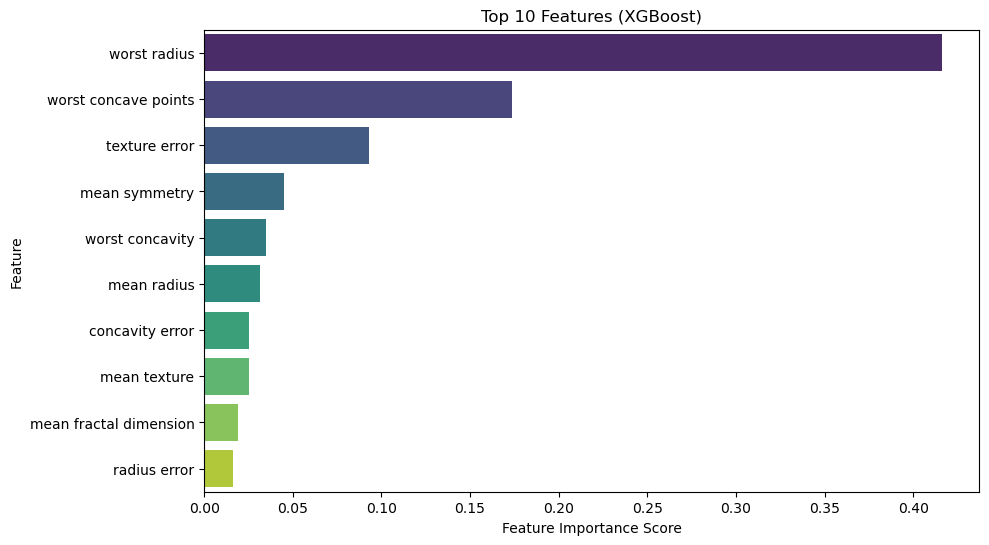

In [ ]:
# Get feature importance
feature_importance = xgb_model.feature_importances_

# Create DataFrame of feature importance
importance_df = pd.DataFrame({"Feature": X.columns, "Importance": feature_importance})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Display top features
print("\n🔹 Top Features for Deployment:")
print(importance_df.head(10))

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x=importance_df["Importance"][:10], y=importance_df["Feature"][:10], palette="viridis")
plt.xlabel("Feature Importance Score")
plt.ylabel("Feature")
plt.title("Top 10 Features (XGBoost)")
plt.show()

In [ ]:
selected_features = ["worst radius", "worst concave points", "texture error",
                     "mean symmetry", "worst concavity", "mean radius", "concavity error","mean texture","mean fractal dimension","radius error"]
X_selected = X[selected_features]


In [ ]:
X_train_selected = X_train[selected_features]  # Select features from training set
X_test_selected = X_test[selected_features]


In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X) 
X_train = scaler.fit_transform(X_train_selected)
X_test = scaler.transform(X_test_selected)

In [ ]:
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [ ]:
y_pred = xgb_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"RandomForest: Accuracy with selected of features: {accuracy}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

RandomForest: Accuracy with selected of features: 0.958041958041958
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.96        74
           1       0.98      0.93      0.96        69

    accuracy                           0.96       143
   macro avg       0.96      0.96      0.96       143
weighted avg       0.96      0.96      0.96       143



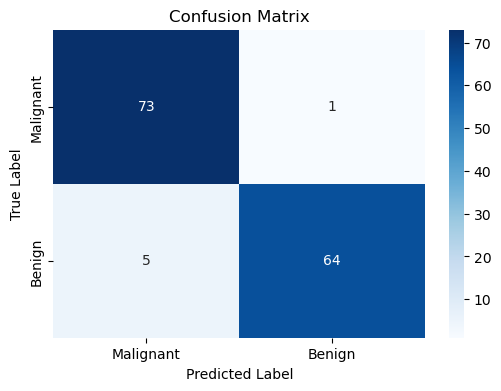

In [ ]:
new_conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(new_conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Malignant", "Benign"], yticklabels=["Malignant", "Benign"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
import joblib
joblib.dump(xgb_model, "xgboost_model.pkl")
joblib.dump(scaler,"scal.pkl")

joblib.dump(selected_features,"selectedfeat.pkl")



['selectedff.pkl']